In [9]:
from pathlib import Path 

import numpy as np 
import matplotlib.pyplot as plt 
import scipy

import CompPhy as cp 

plt.style.use("custom.matplotlibrc")

DIR = (Path("./") / "Exercise_6").resolve()

def generate_checkerboard(N: int):
    b1 = np.array([-1, 1] * (N // 2))
    b2 = np.array([1, -1] * (N // 2))
    return np.array([b1, b2] * (N // 2))

# 1. Spontaneous Magnetization

In [2]:
np.random.seed(1)
j_scan = dict()

J = [0.1, 0.2, 0.5 * np.log(1 + np.sqrt(2)), 0.7, 0.8]
def do_j_scan(N: int, SAMPLE_SIZE: int):

    b1 = np.array([-1, 1] * (N // 2))
    b2 = np.array([1, -1] * (N // 2))
    start_cfg = np.array([b1, b2] * (N // 2))

    fig, ax = plt.subplots(1, 5, figsize=(15, 5), sharey=True)

    color_cycle = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    for i, j in enumerate(J):
        model = cp.Ising2D(lattice_sites=N, j=j, h=0)

        sample = model.generate_sample(SAMPLE_SIZE, start_cfg)
        m = np.abs(sample.mean(axis = (1, 2)))
        j_scan[f"{N} {j}"] = m

        ax[i].hist(m, density=True, bins=10, label=f"$J = {"{:.2f}".format(j)}$", orientation="horizontal", color=color_cycle[i])
        ax[i].legend(frameon=True)

    fig.supxlabel("PDF")
    # fig.suptitle(f"$N = {N}$")
    fig.savefig(DIR / f"j_scan_{N}.pdf")


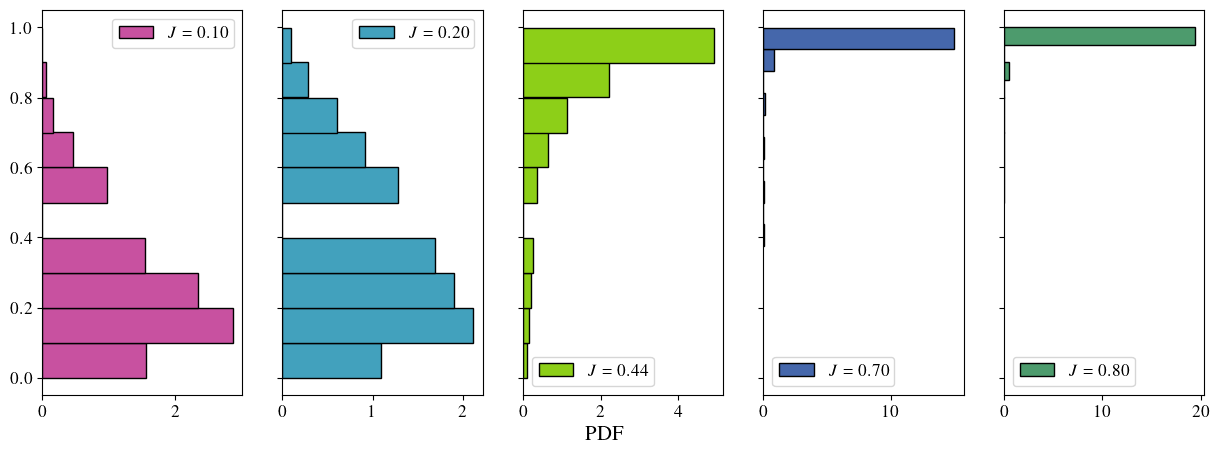

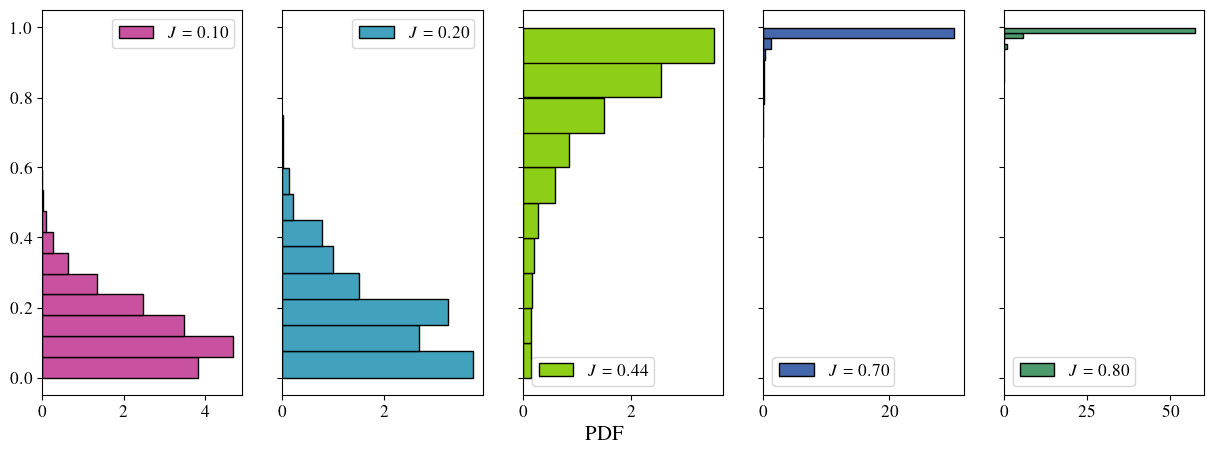

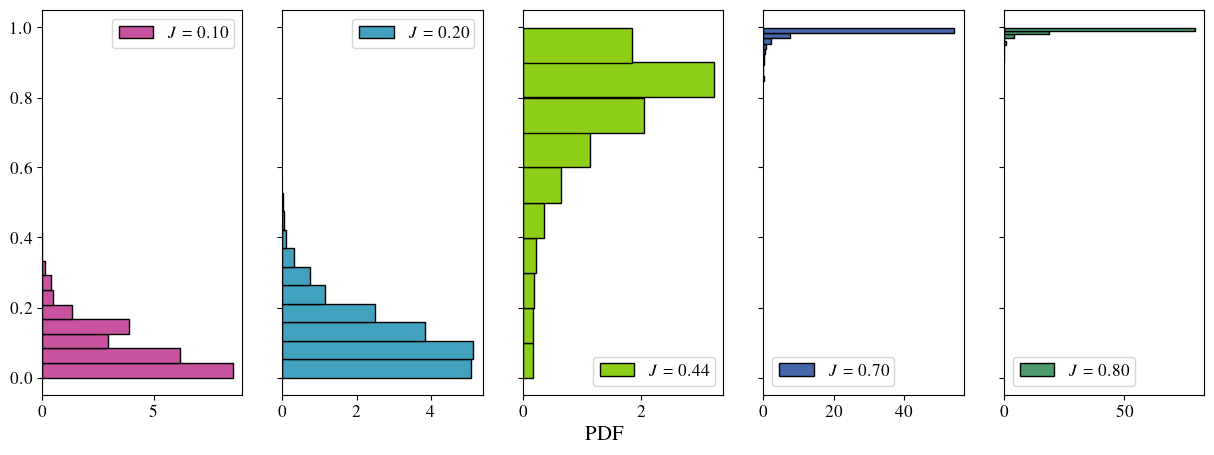

In [3]:
np.random.seed(2)
for N in [4, 8, 12]:
    do_j_scan(N, 10_000)

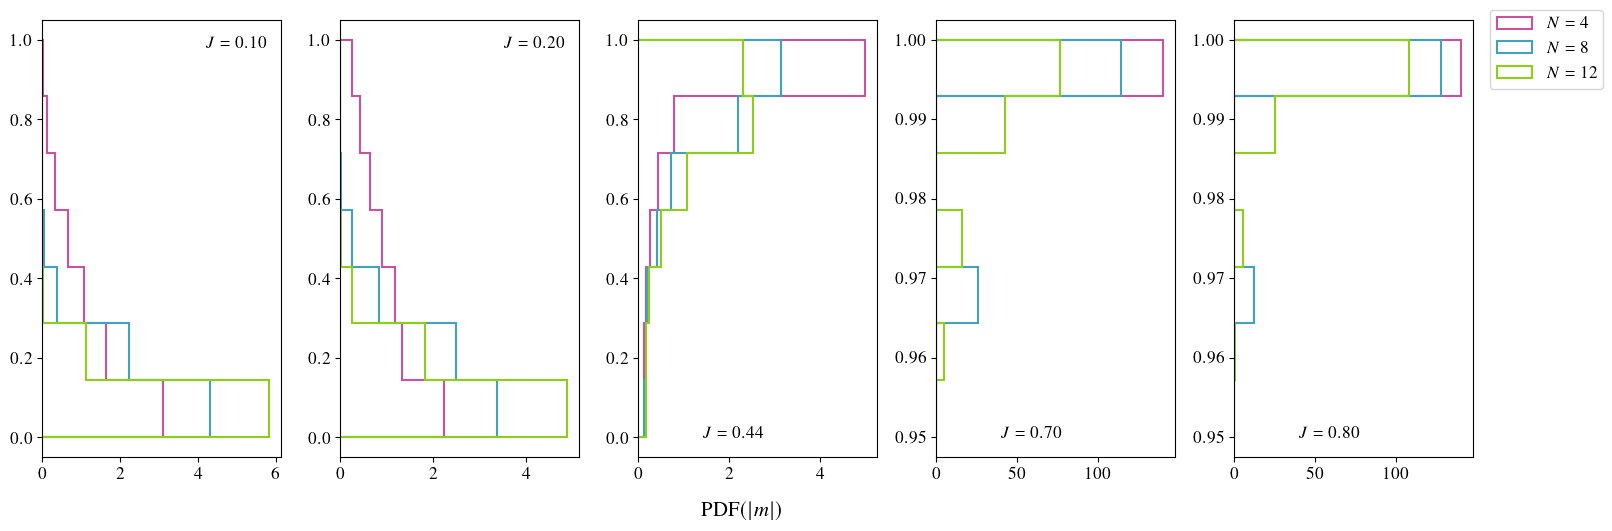

In [ ]:
# fig, ax = plt.subplots(1, len(J), figsize=(15, 5))
fig = plt.figure(1, figsize=(15, 5))
handles, labels = [], []
ax = None
for i, j in enumerate(J):
    for N in [4, 8, 12]:
        m = j_scan[f"{N} {j}"]
        if i < 6:
            ax = plt.subplot(1, 5, i + 1)
            rng = (0, 1)
            if i > 2:
                rng = (0.95, 1)
            plt.hist(m, label=f"$N = {N}$", density=True, orientation="horizontal", alpha=1, histtype="step", bins=7, range=rng, lw=1.5)
            plt.legend(handles=[plt.Line2D([0], [0], label=f"$J = {"{:.2f}".format(j)}$", linestyle="")], frameon=False)
        # else:
        #     plt.subplot(2, 5, i + 1)
        #     plt.hist(m, label=f"$N = {N}$", density=True, orientation="horizontal", alpha=1, histtype="step", bins=15, range=(0.75, 1))
        #     plt.subplot(2, 5, i + 6)
        #     plt.hist(m, label=f"$N = {N}$", density=True, orientation="horizontal", alpha=1, histtype="step", bins=15, range=(-1, -0.75))

fig.tight_layout()
# lgd = fig.legend()
# handles, labels = lgd.legend_handles[:3], lgd.legend_labels[:3]
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(1.08, 1))
fig.supxlabel(r"$\text{PDF}(\abs{m})$", y = -0.04)
fig.savefig(DIR / "j_scan_compare_n.pdf", bbox_inches="tight")
    

# 2. Scanning $J$

## Exact Results

In [3]:
J_c = 0.5 * np.log(1 + np.sqrt(2))
@np.vectorize
def mean_mag_per_site(J):

    if J <= J_c:
        return 0

    return np.power(1 - 1 / np.sinh(2 * J) ** 4, 0.125)


def mean_energy_per_site(J):
    tanh2 = np.tanh(2 * J) ** 2
    fac = -J * np.cosh(2 * J) / np.sinh(2 * J)
    term1 = 2 * tanh2 - 1
    term2 = scipy.special.ellipk(4 * (1 - tanh2) * tanh2)

    return fac * (1 + 2 / np.pi * term1 * term2)

## Generate Ensembles

In [4]:
np.random.seed(10)
N = [4, 8, 12]
J = np.round(np.arange(1, 4, .1), 1)
barstyle = {
    "lines.linestyle": "",
    "lines.marker": "o",
}

def generate_ensembles(J: float, N: int):
    model = cp.Ising2D(j=J, h=0, lattice_sites=N)
    sample = model.generate_sample(3_000, generate_checkerboard(N))
    np.save(DIR / f"ensemble_{J}_{N}", sample)

# for n in N:
#     for j in J:
#         generate_ensembles(j, n)

## $|m|$ Scan

NameError: name 'mean_mag_per_site' is not defined

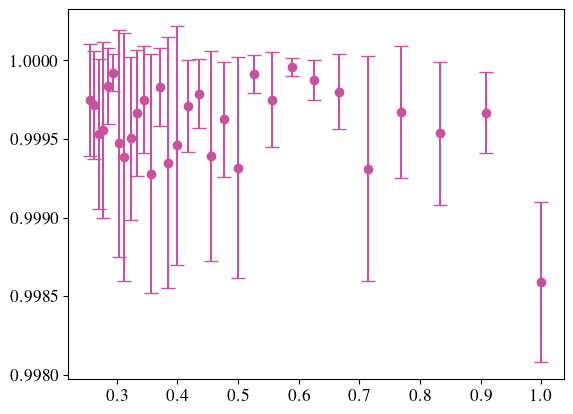

In [4]:
def do_bootstrap(J: float, N: int) -> tuple[float, float]:
    sample = np.load(DIR / f"ensemble_{J}_{N}.npy")
    m_sample = np.abs(sample.mean(axis=(1, 2)))
    tau = int(np.ceil(cp.integrated_autocorrelation(m_sample)))
    m_sample = cp.blocking(m_sample, tau=tau)
    m_len = len(m_sample)
    if tau > 20:
        # Give a warning if some calculation did not work as expected and exclude from result
        print(f"Warning: tau = {tau} for J = {J} N = {N}")
        return 0, 0
    return cp.Bootstrap(m_sample, m_len // 2, m_len // 2).estimate(lambda x: x)


colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
for n in N:
    plt.figure(n)
    m = np.array([[*do_bootstrap(j, n)] for j in J])
    with plt.rc_context(barstyle):
        plt.errorbar(1 / J, m[:, 0], yerr=m[:, 1], zorder=100, capsize=5, color=colors[n // 4 - 1], label="Data")
        x = np.linspace(1, 4, 100)
    plt.plot(1 / x, mean_mag_per_site(x), lw=1.5, color="black", label="Analytical")
    plt.ylim((0.99, 1.002))
    plt.xlabel("$1 / J$")
    plt.ylabel(r"$\abs{m}$")
    plt.legend(loc="lower right")
    plt.savefig(DIR / f"ex6.2_jscan_{n}.pdf")

## $\epsilon$ Scan

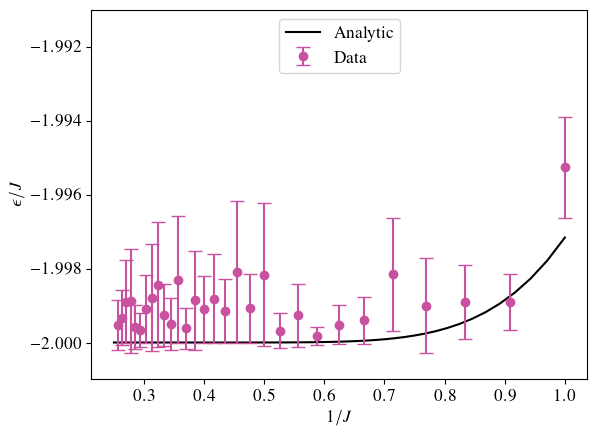

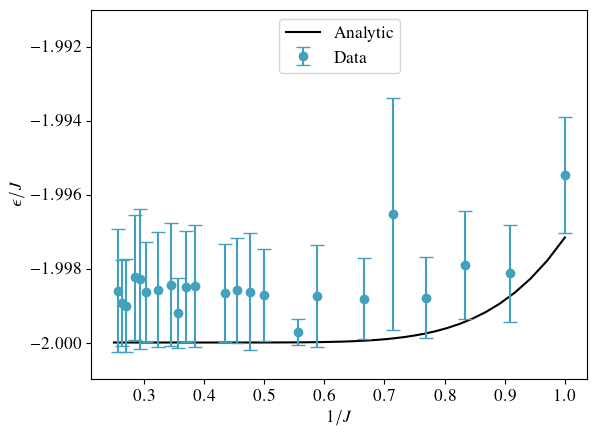

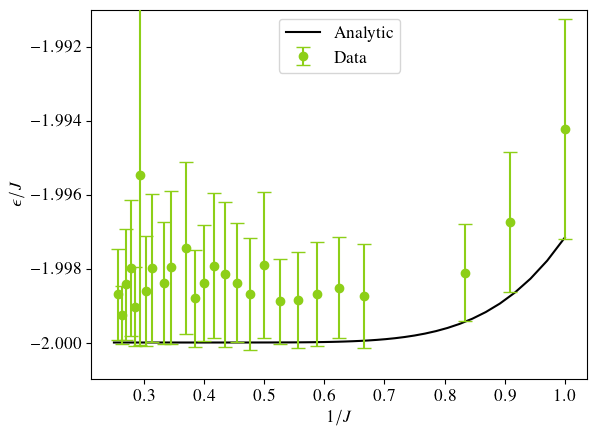

In [31]:
def do_e_bootstrap(J: float, N: int) -> tuple[float, float]:
    sample = np.load(DIR / f"ensemble_{J}_{N}.npy")
    model = cp.Ising2D(N, J, 0)
    e = model.calc_energy(sample) / N**2
    tau = cp.integrated_autocorrelation(e)
    if tau > 20:
        print(f"Warning: tau = {tau} for J = {J} N = {N}")
        return 0, 0
    
    e = cp.blocking(e, tau=tau) 
    btrp = cp.Bootstrap(e, len(e) // 2, len(e) // 2)
    return btrp.estimate(lambda x: x)

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
for n in N:
    plt.figure(n)
    e = np.array([[*do_e_bootstrap(j, n)] for j in J])

    with plt.rc_context(barstyle):
        plt.errorbar(1 / J, e[:, 0] / J, yerr=e[:, 1] / J, capsize=5, color=colors[n // 4 - 1], label="Data", zorder=100)
    x = np.linspace(1, 4, 100)
    plt.plot(1 / x, mean_energy_per_site(x) / x, color="black", label="Analytic")
    plt.ylim((-2.001, -1.991))
    plt.xlabel(r"$1 / J$")
    plt.ylabel(r"$\epsilon / J$")
    plt.legend(loc="upper center")
    plt.savefig(DIR / f"6.2_jsan_e_{n}.pdf")